<a href="https://colab.research.google.com/github/taxfree-python/quantum_computer_demo/blob/main/quantum_order_finding_subroutine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[これ](https://www.shuwasystem.co.jp/support/7980html/6280.html)を参考に新しいqiskitに対応させた

In [1]:
!pip install qiskit
!pip install qiskit-aer
!pip install pylatexenc

In [14]:
import numpy as np
from numpy import pi
import math
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit.providers.basic_provider import BasicSimulator

# from qiskit_aer import AerSimulator

In [45]:
def cmul_mod15(repetitions):
    U = QuantumCircuit(4)
    for i in range(repetitions):
        U.swap(3, 2)
        U.swap(2, 1)
        U.swap(1, 0)
    U = U.to_gate()
    c_U = U.control(1)
    return c_U

In [46]:
# 逆量子フーリエ変換
def qft_rotate_single_inv(circuit, i, n):
    if n == 0:
        return circuit
    for qubit in range(0, i):
        circuit.cp(-pi/2**(i - qubit), qubit, i)
    circuit.h(i)

def qft_dagger(circuit, n):
    for i in range(math.floor(n/2)):
        circ.swap(i, n - (i + 1))
    for i in range(n):
        qft_rotate_single_inv(circuit, i, n)

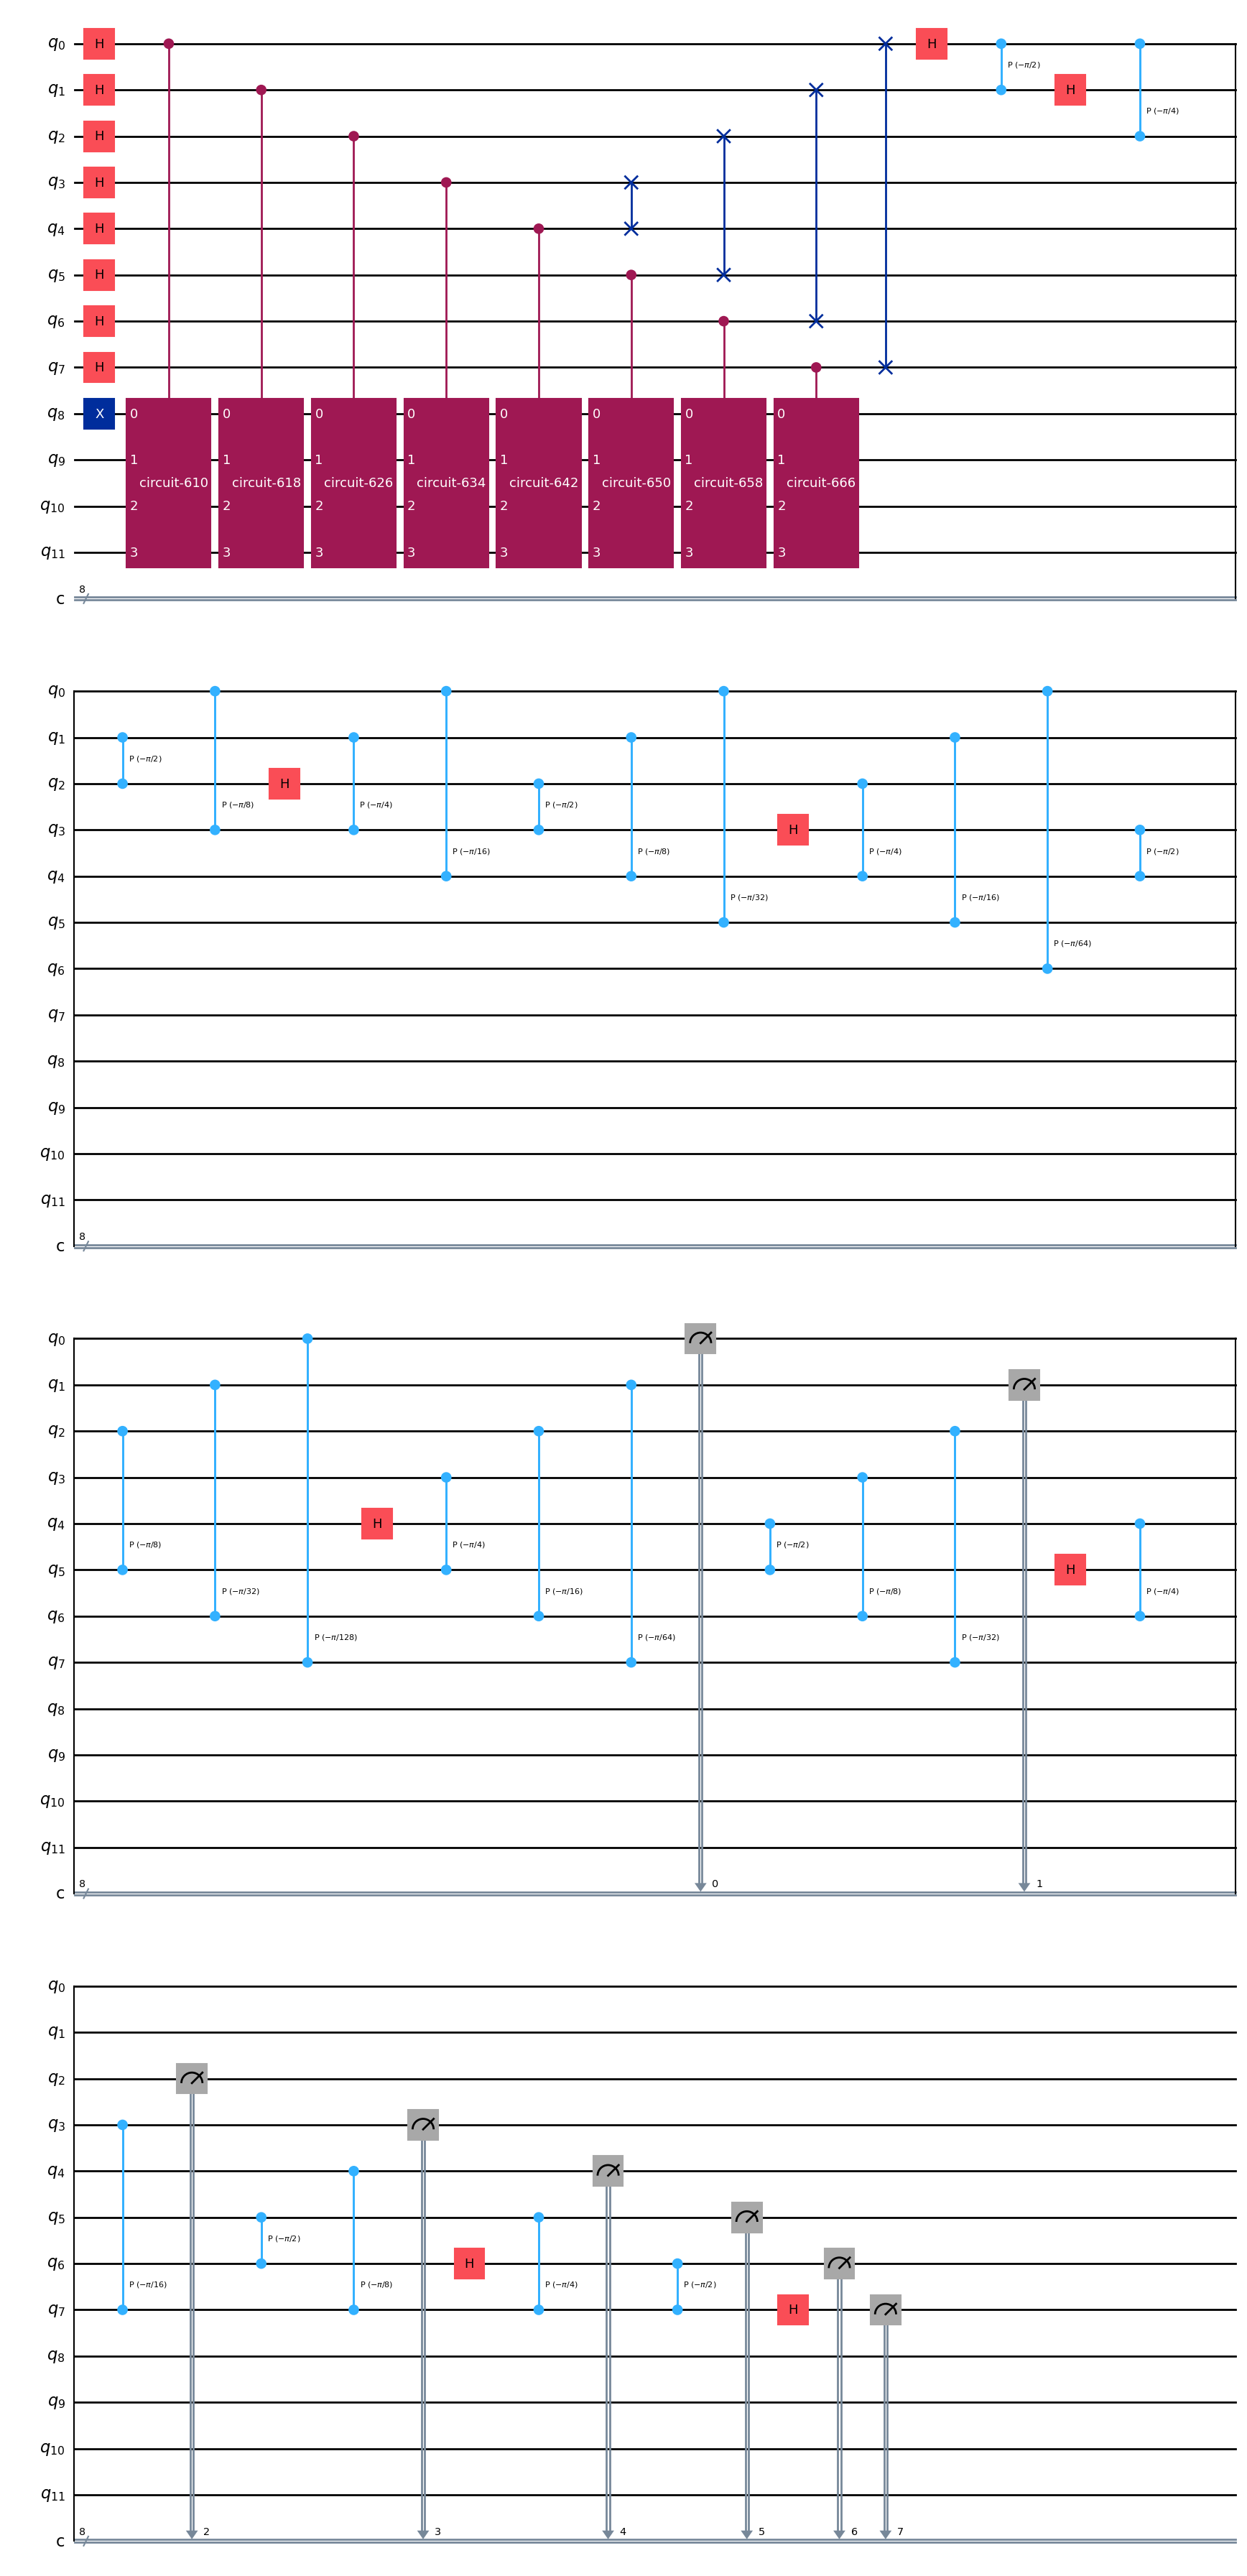

In [47]:
# アルゴリズムの本体
n_encode = 8  # 求めたい固有値の位相角をエンコードする量子ビット数
n_eigstate = 4 # 固有状態の量子ビット数
circ = QuantumCircuit(n_encode +n_eigstate , n_encode)

for i in range(n_encode):
    circ.h(i)
circ.x(n_encode)

repetitions = 1
for count in range(n_encode):
    circ.append(cmul_mod15(repetitions),
         [count] + [8, 9, 10, 11])
    repetitions *= 2

qft_dagger(circ, 8)

for i in range(n_encode):
    circ.measure(i,i)

circ.draw('mpl')

In [48]:
backend = BasicSimulator()
tqc = transpile(circ, backend)
counts = backend.run(tqc).result().get_counts()

result = [(key, int(key, 2)/2**n_encode) for key in counts.keys()]
result.sort(key=lambda x: x[1], reverse=True)

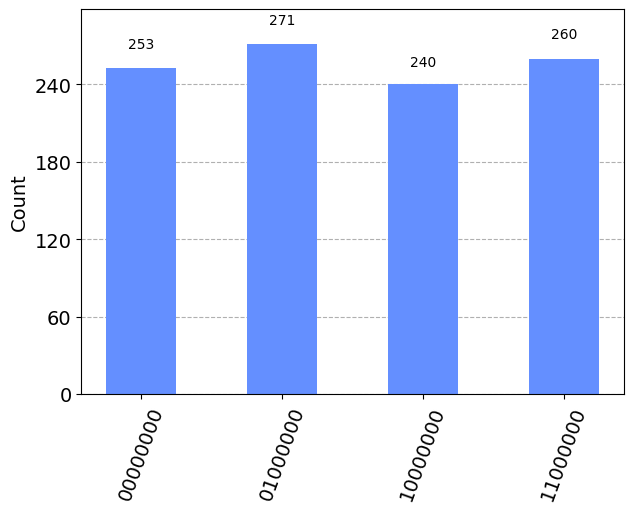

In [49]:
plot_histogram(counts)

In [54]:
result

[('00000000', 0.0), ('01000000', 0.25), ('10000000', 0.5), ('11000000', 0.75)]

得られた結果は量子位相推定アルゴリズムからの出力であり，各基底状態の位相（角度）を表している．ここでの目的は，この位相情報を使用して乗算の位数を計算することである．$N=15$, $x=2$のケースにおいて，得られた結果を分析することで位数を見つけ出すことができる．

結果は，4つの異なる基底状態（'00000000', '01000000', '10000000', '11000000'）とそれに対応する位相（0.0, 0.25, 0.5, 0.75）を含んでいる．これらの位相は，乗算における位数の逆数と関連している．具体的には，位相は次の形式で表される：

$ \text{位相} = \frac{k}{r} $

ここで，$k$は整数で，$r$は求めたい位数である．

### 位数の計算手順

1. **位相から分数を作成する**：各位相を使って，位数の候補である分数を作成する．たとえば，位相が0.25の場合，これは分数($\frac{1}{4}$)を意味し，したがって位数($r$)の候補は4である．

2. **位数の確認を行う**：位数($r$)が正しいかどうかを確認するために，($x^r \mod N$)が1に等しいかを確認する．この場合，($x=2$)，($N=15$)であり，位数の候補をこの式に代入して検証する．

### 例

- 位相0.0の場合は，分数を作ることができない（これは位数の計算には直接関与しない）．
- 位相0.25の場合，分数は\($\frac{1}{4}$)である．これは位数($r=4$)を意味する．
- 位相0.5の場合，分数は\($\frac{1}{2}$)である．これは位数($r=2$)を意味するが，このケースでは位相が大きいため考慮しない．
- 位相0.75の場合，分数は\($\frac{3}{4}$)であるが，これは位数の有効な候補ではない．

このケースでは，位相0.25から位数($r=4$)が最も妥当な候補として導出される．最終的に，\($2^4 \mod 15 = 1$)が成り立つかを確認することで，位数が正しく4であることを検証できる．

位数が求められれば，その数を使用してさらに多くの量子アルゴリズムや計算で利用することが可能である．たとえば，ショアのアルゴリズムでは，この位数を使用して大きな数の素因数分解を行うことができる．
